In [8]:
# autoload
%load_ext autoreload
%autoreload 2

import sys
import pandas as pd
# append path
sys.path.append('../')
from scipy.special import logit

from process.tables import *
from models.bayes import *
from models.predict import *
from process.config import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
def plot_hazard_ratios(results_data, outcome_name, save=False):
    plt.figure(figsize=(3, 12), dpi=200)
    colors = sns.color_palette('husl', n_colors=results_data['interval_type'].nunique())
    
    test_names = results_data['test_name'].unique()
    y_positions = np.arange(len(test_names))
    offsets = np.linspace(-0.2, 0.2, len(results_data['interval_type'].unique()))
    
    sample_size = {t: s for t, s in zip(results_data['test_name'], results_data['num_measurements'])}
    y_labels = [f'{t} (n={sample_size[t]})' for t in results_data['test_name'].unique()]
        
    for i, interval in enumerate(results_data['interval_type'].unique()):
        subset = results_data[results_data['interval_type'] == interval]
        y_pos = [np.where(test_names == t)[0][0] for t in subset['test_name']]
        
        plt.errorbar(
            subset['hazard_ratio'], 
            [y + offsets[i] for y in y_pos],
            xerr=[
                (subset['hazard_ratio'] - subset['ci_lower']),
                (subset['ci_upper'] - subset['hazard_ratio'])
            ],
            fmt='o',
            markersize=4,
            label=interval.capitalize(),
            color=colors[i],
            capsize=2,
            elinewidth=1
        )
    plt.yticks(y_positions, y_labels)
    x_max = np.minimum(10, results_data['ci_upper'].max())
    plt.xlim(0, x_max)
    plt.xlabel('Hazard Ratio')
    plt.ylabel('Test Name')
    plt.axvline(x=1, color='gray', ls='--', alpha=0.3)
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.grid(True, alpha=0.3, linestyle='--')
    
    if save:
        outfile = f'../results/figures/{outcome_name}_hr.png'
        os.makedirs(os.path.dirname(outfile), exist_ok=True)
        plt.savefig(outfile)
    plt.show()
    
def get_metrics(test_data, interval_types, time_points, outcome, threshold_percentiles=False, n_bootstraps=1000):
    # Store all results
    all_results = pd.DataFrame()
    for test_code in test_data['test_name'].unique():
        test_subset = test_data[test_data['test_name'] == test_code]
        
        for interval in interval_types:
            # Get predictions
            try: 
                model_path = f'../results/models/{outcome}/cox_model_{test_code}_{interval}.pkl'
                predictions = predict_survival(model_path, test_subset, time_points)
                for year in time_points:
                    y_pred, y_true = predictions[f'{year}yr'], predictions[f'event_{year}yr']
                    
                    base_result = {
                        'test_name': test_code,
                        'interval_type': interval.capitalize(),
                        'time_point': year
                    }
                    
                    # Calculate AUC
                    auc_stats = bootstrap_metric(y_true, y_pred, calculate_auc, n_bootstraps)
                    results = pd.DataFrame([{
                        **base_result,
                        'metric': 'auc',
                        'value': auc_stats['mean'],
                        'ci_lower': auc_stats['ci_lower'],
                        'ci_upper': auc_stats['ci_upper'],
                    }])
                    
                    # Calculate sensitivity/specificity at different thresholds
                    if threshold_percentiles:
                        percentiles = np.linspace(0, 1, 10)
                        thresholds = [np.percentile(y_pred, p * 100) for p in percentiles]
                    else:
                        thresholds = np.linspace(0, 1, 10)
                        percentiles = [None for _ in thresholds]
                        
                    for i, threshold in enumerate(thresholds):
                        # Calculate both metrics at once
                        for metric_name, metric_func in [
                            ('sensitivity', calculate_sensitivity),
                            ('specificity', calculate_specificity)
                        ]:
                            value = metric_func(y_true, y_pred, threshold)
                            
                            results = pd.concat([results, pd.DataFrame([{
                                **base_result,
                                'metric': metric_name,
                                'value': value,
                                'ci_lower': None,
                                'ci_upper': None,
                                'threshold': threshold,
                                'percentile': percentiles[i]
                            }])])
                    
                    all_results = pd.concat([all_results, results])
            except:
                pass
    return all_results

# Plot AUC 
def plot_auc_comparison(results_df, time_point=10, outcome_name=None, save=False):
    n_interval_types = results_df['interval_type'].unique().size
    df = results_df.query('time_point == @time_point and metric == "auc"')

    # X-axis mapping and offsets
    interval_types = df['interval_type'].unique()
    interval_offsets = {interval: i * 0.2 for i, interval in enumerate(interval_types)}
    unique_tests = df['test_name'].unique()
    test_to_x = {test: i*1.1 for i, test in enumerate(unique_tests)}  # Increased spacing between x-ticks
    df['x_base'] = df['test_name'].map(test_to_x)
    df['x'] = df['x_base'] + df['interval_type'].map(interval_offsets)

    colors = sns.color_palette('husl', n_colors=n_interval_types)

    # Plot
    plt.figure(figsize=(12, 2))  # Increased figure width
    for i, interval in enumerate(df['interval_type'].unique()):
        subset = df[df['interval_type'] == interval]
        yerr = [
            subset['value'] - subset['ci_lower'],
            subset['ci_upper'] - subset['value']
        ]
        plt.errorbar(subset['x'], subset['value'], yerr=yerr,
                    fmt='o', markersize=4, capsize=3, label=interval, 
                    color=colors[i], elinewidth=1)

    plt.xticks(ticks=list(test_to_x.values()), labels=list(test_to_x.keys()), rotation=45)
    plt.xlabel('')
    plt.ylabel('AUC')
    plt.ylim(0.4, 1.1)
    plt.grid(True, alpha=0.3, linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.legend(bbox_to_anchor=(0.5, 1.45), loc='upper center', title='Interval Type', 
              ncol=n_interval_types, frameon=False)
    
    if save:
        outfile = f'../results/figures/{outcome_name}_{time_point}yr_auc.png'
        os.makedirs(os.path.dirname(outfile), exist_ok=True)
        plt.savefig(outfile)
    plt.show()
    
def plot_sensitivity_specificity(results_df, time_point=10, outcome_name=None, save=False):
    # Prepare data
    sensitivity = results_df.query('time_point == @time_point and metric == "sensitivity"')
    specificity = results_df.query('time_point == @time_point and metric == "specificity"')
    sensitivity['metric'] = 'sensitivity'
    specificity['metric'] = 'specificity'
    combined = pd.concat([sensitivity, specificity])
    n_interval_types = combined['interval_type'].unique().size
    
    # Setup
    test_names = combined['test_name'].unique()
    line_styles = {'sensitivity': '--', 'specificity': '-'}
    colors = sns.color_palette('husl', n_colors=n_interval_types)

    # Create subplot grid - 1 row, 4 columns
    cols = len(test_names)
    rows = 1
    fig, axes = plt.subplots(rows, cols, figsize=(16, 3), sharex=True, sharey=True)

    # Plot each test
    for idx, test in enumerate(test_names):
        x_axis = 'percentile' if not combined['percentile'].isnull().all() else 'threshold'
        ax = axes[idx]
        subset = combined[combined['test_name'] == test]

        for i, interval in enumerate(results_df['interval_type'].unique()):
            for metric in ['sensitivity', 'specificity']:
                data = subset[(subset['metric'] == metric) & (subset['interval_type'] == interval)]
                if not data.empty:
                    ax.plot(
                        data[x_axis],
                        data['value'],
                        linestyle=line_styles[metric],
                        color=colors[i],
                        alpha=1,
                        linewidth=1.5
                    )

        ax.set_title(test, fontsize=10, pad=5)
        ax.set_xlabel('Threshold Percentile' if x_axis == 'percentile' else 'Threshold Value', fontsize=8)
        
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(labelsize=8)
        ax.axvline(x=0.75, color='gray', linestyle='--', alpha=0.5)
        
        if idx == 0:
            ax.set_ylabel('Performance', fontsize=8)

    # Create unified legend
    legend_elements = [
        plt.Line2D([0], [0], color='gray', linestyle='--', label='Sensitivity', linewidth=1.5),
        plt.Line2D([0], [0], color='gray', linestyle='-', label='Specificity', linewidth=1.5)
    ]
    for i, interval in enumerate(results_df['interval_type'].unique()):
        legend_elements.append(plt.Line2D([0], [0], color=colors[i], label=interval.capitalize(), linewidth=1.5))

    fig.tight_layout()
    fig.legend(
        handles=legend_elements,
        bbox_to_anchor=(0.5, -0.05),
        loc='center',
        ncol=n_interval_types + 2,
        fontsize=8,
        frameon=False
    )
    
    if save:
        outfile = f'../results/figures/{outcome_name}_{time_point}yr_sensitivity_specificity.png'
        os.makedirs(os.path.dirname(outfile), exist_ok=True)
        plt.savefig(outfile, bbox_inches='tight', dpi=300)
    plt.show()


## Process Data

In [34]:
def run_pipeline(method_str, min_days=1, max_days=365*1, year_pred=5):
    reference_data = pd.read_csv(f'../results/bayes/bayes_{method_str}.csv')
    setpoint_df = pd.read_csv(f'../results/setpoints/setpoints_{method_str}.csv') #[['subject_id', 'test_name', 'setpoint_mean', 'setpoint_var']]
    smoothed_df = pd.read_csv(f'../results/smoothed/smoothed_{method_str}.csv')
    ou_df = pd.read_csv(f'../results/ou/ou_{method_str}.csv').drop(columns=['sex'])
    reference_data = setpoint_df.merge(reference_data, on=['subject_id', 'test_name'], how='left')
    reference_data = smoothed_df.merge(reference_data, on=['subject_id', 'test_name'], how='left')
    reference_data = ou_df.merge(reference_data, on=['subject_id', 'test_name'], how='left')

    # print the number of subjects in the reference data
    print(f'Number of subjects in the reference data: {reference_data["subject_id"].nunique()}')

    lab_measurements = pd.read_csv('../data/processed/all_lab_measurements.csv')[['subject_id', 'test_name', 'numeric_value', 'time', 'age']]
    outcomes_df = pd.read_csv('../data/processed/outcomes_df.csv')

    processed_data = extract_followup_labs(reference_data, lab_measurements, min_days=min_days, max_days=max_days)
    print(processed_data.subject_id.nunique())

    processed_data = check_within_interval(processed_data, 'obs_mean', 'prior_mean', 'prior_var', 'reference_interval')
    processed_data = check_within_interval(processed_data, 'post_mean', 'prior_mean', 'prior_var', 'post_reference_interval')
    processed_data = check_within_interval(processed_data, 'setpoint_mean', 'prior_mean', 'prior_var', 'setpoint_reference_interval')
    processed_data = check_within_interval(processed_data, 'numeric_value', 'prior_mean', 'prior_var', 'reference')
    processed_data = check_within_interval(processed_data, 'numeric_value', 'obs_mean', 'obs_var', 'observed')
    processed_data = check_within_interval(processed_data, 'numeric_value', 'post_mean', 'post_var', 'bayes')
    processed_data = check_within_interval(processed_data, 'numeric_value', 'setpoint_mean', 'setpoint_var', 'setpoint')
    processed_data = check_within_interval(processed_data, 'numeric_value', 'smoothed_x_mean', 'smoothed_x_var', 'smoothed')
    processed_data = check_within_interval(processed_data, 'numeric_value', 'ou_mean', 'ou_var', 'ou')

    processed_data = convert_to_category(processed_data, 'sex')

    processed_data = processed_data.merge(outcomes_df, on=['subject_id'], how='left')
    print([group.subject_id.nunique() for code, group in processed_data.groupby('test_name')])
    
    tests = CBC_REFERENCE_INTERVALS.keys()
    remove = ['GGT', 'A1C', 'PT', 'DBIL', 'CRP']
    #processed_data = processed_data[processed_data['test_name'].isin(tests)]
    processed_data = processed_data[~processed_data['test_name'].isin(remove)]
    
    outcomes = ['mortality', 't2d', 'mace', 'ckd'] #, 'af', 'hypertension', 'hyperlipidemia', 'ckd', 'osteo', ]
    interval_types = ['reference', 'setpoint', 'smoothed', 'bayes', 'ou']
    years = [1, 3, 5, 7]
    year = year_pred

    for outcome in outcomes:
        print(outcome)
        df = calculate_survival_time(processed_data, outcome + '_date')

        if outcome == 't2d':
            # remove the rows where the numeric_value is above 200 and event_status is 0 
            # get the rows where the numeric value for the test_name "GLU" is above 200 and event_status is 0 
            remove_ids = df.query('test_name == "GLU" and numeric_value > 200 and event_status == 0')['subject_id'].unique()
            df = df[~df['subject_id'].isin(remove_ids)]
            
        observed_within_reference = df.query('not_within_post_reference_interval_interval == 0')
        
        # observed_within_reference.loc[observed_within_reference['not_within_reference_interval'] == 1, 'not_within_observed_interval'] = 1
        # observed_within_reference.loc[observed_within_reference['not_within_reference_interval'] == 1, 'not_within_setpoint_interval'] = 1
        # observed_within_reference.loc[observed_within_reference['not_within_reference_interval'] == 1, 'not_within_bayes_interval'] = 1
        # observed_within_reference.loc[observed_within_reference['not_within_reference_interval'] == 1, 'not_within_smoothed_interval'] = 1
        
        # for each test_name, can you print the correlation between the not_within_reference_interval and the event_status
        # for test_name in observed_within_reference['test_name'].unique():
        #     print(test_name)
        #     print(observed_within_reference.query('test_name == @test_name')[['not_within_reference_interval', 'event_status']].corr().iloc[0,1])
        #     print(observed_within_reference.query('test_name == @test_name')[['not_within_setpoint_interval', 'event_status']].corr().iloc[0,1])
        #     print(observed_within_reference.query('test_name == @test_name')[['not_within_bayes_interval', 'event_status']].corr().iloc[0,1])
        #     print(observed_within_reference.query('test_name == @test_name')[['not_within_smoothed_interval', 'event_status']].corr().iloc[0,1])
        
        train_data, test_data = stratified_train_test_split(observed_within_reference, test_size=0.3)
        print([group.subject_id.nunique() for code, group in train_data.groupby('test_name')])
        print('Train Data Positive :', [(code, sum(group.event_status)) for code, group in train_data.groupby('test_name')])
        print('Test Data Positive :', [(code, sum(group.event_status)) for code, group in test_data.groupby('test_name')])
        observed_within_reference['not_within_reference_interval'] = observed_within_reference['not_within_reference_interval'].astype(int)
        survival_results = run_survival_analysis(train_data, outcome_name=outcome, interval_types=interval_types)
        plot_hazard_ratios(survival_results, outcome_name=outcome, save=True)
        
        metrics = get_metrics(test_data, interval_types, [year], outcome, n_bootstraps=10)
        
        # only plot the sensitivity and specificity for the tests that had mean auc > 0.5
        top_tests = metrics.query('metric == "auc"').groupby('test_name').mean('value').sort_values(by='value', ascending=False).head(10).index
        plot_auc_comparison(metrics.query('test_name in @top_tests'), year, outcome_name=outcome, save=True)
        plot_sensitivity_specificity(metrics.query('test_name in @top_tests'), year, outcome_name=outcome, save=True)


In [31]:
# method_str = f'method:index_foy_index_year:2016_min_gap:30_min_tests:5'
# run_pipeline(method_str, min_days=1, max_days=365*1, year_pred=3)

Number of subjects in the reference data: 3907
2978
[347, 1796, 1755, 1762, 1775, 2352, 2356, 2346, 2368, 168, 404, 56, 2364, 2334, 244, 2304, 2400, 11, 122, 2265, 2289, 2288, 2295, 925, 2289, 2292, 1754, 289, 1752, 2298]
mortality
[800, 826, 916, 1046, 1032, 1160, 1326, 1141, 514, 345, 101, 374, 1529, 60, 1061, 1058, 1389, 1261, 421, 631, 234, 161, 1295, 1178]
Train Data Positive : [('ALB', 174), ('ALP', 165), ('ALT', 193), ('AST', 228), ('BUN', 142), ('CA', 209), ('CL', 202), ('CRE', 151), ('GLU', 48), ('HCT', 36), ('HDL', 18), ('HGB', 44), ('K', 227), ('LDL', 15), ('MCH', 201), ('MCHC', 225), ('MCV', 271), ('PLT', 213), ('RBC', 47), ('RDW', 54), ('TBIL', 47), ('TC', 31), ('TP', 435), ('WBC', 180)]
Test Data Positive : [('ALB', 74), ('ALP', 70), ('ALT', 83), ('AST', 97), ('BUN', 61), ('CA', 90), ('CL', 86), ('CRE', 65), ('GLU', 20), ('HCT', 16), ('HDL', 8), ('HGB', 19), ('K', 97), ('LDL', 6), ('MCH', 86), ('MCHC', 96), ('MCV', 116), ('PLT', 91), ('RBC', 20), ('RDW', 23), ('TBIL', 20)

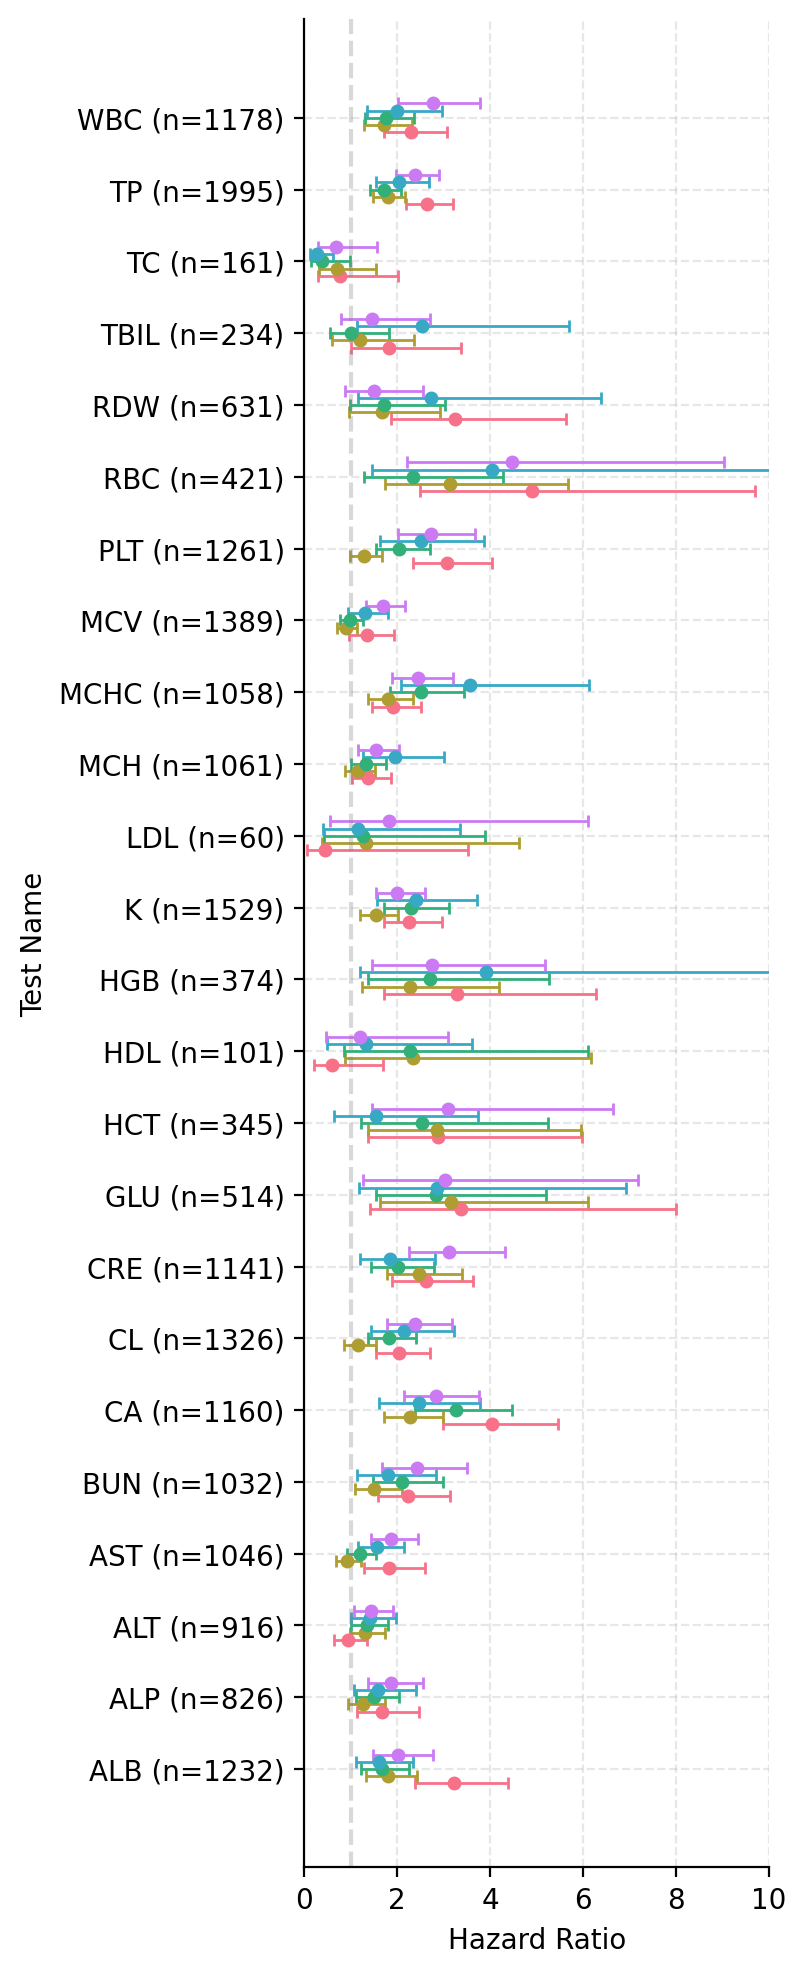

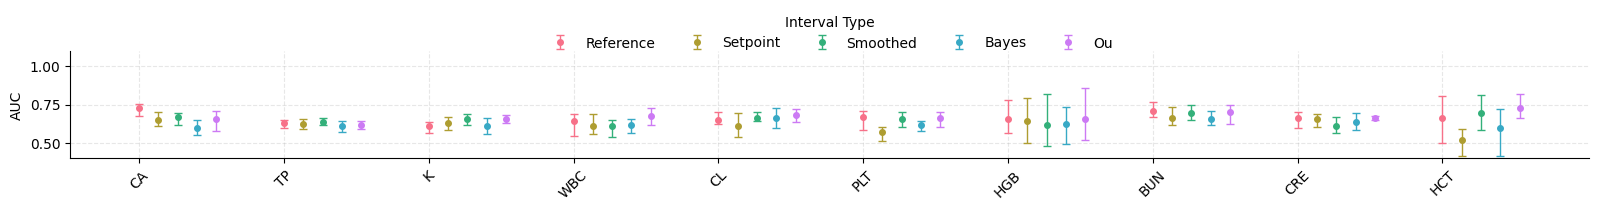

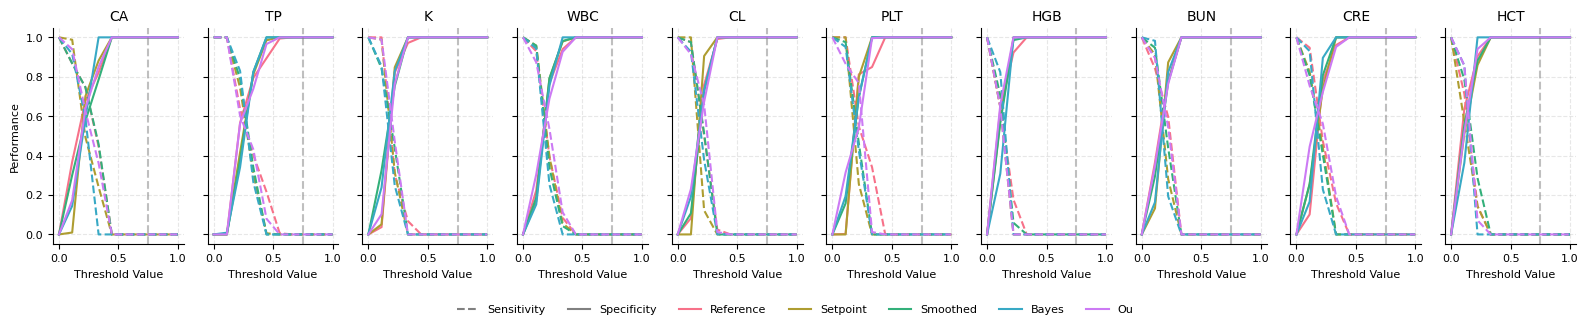

t2d
[549, 554, 594, 676, 712, 755, 856, 775, 412, 266, 48, 294, 975, 20, 699, 740, 917, 842, 312, 462, 148, 79, 820, 782]
Train Data Positive : [('ALB', 45), ('ALP', 32), ('ALT', 31), ('AST', 38), ('BUN', 20), ('CA', 46), ('CL', 24), ('CRE', 18), ('GLU', 8), ('HCT', 13), ('HDL', 9), ('HGB', 15), ('K', 25), ('LDL', 3), ('MCH', 33), ('MCHC', 34), ('MCV', 41), ('PLT', 41), ('RBC', 15), ('RDW', 11), ('TBIL', 6), ('TC', 15), ('TP', 59), ('WBC', 24)]
Test Data Positive : [('ALB', 20), ('ALP', 13), ('ALT', 13), ('AST', 16), ('BUN', 9), ('CA', 19), ('CL', 10), ('CRE', 8), ('GLU', 3), ('HCT', 5), ('HDL', 4), ('HGB', 6), ('K', 11), ('LDL', 1), ('MCH', 14), ('MCHC', 15), ('MCV', 18), ('PLT', 18), ('RBC', 7), ('RDW', 4), ('TBIL', 2), ('TC', 6), ('TP', 25), ('WBC', 10)]


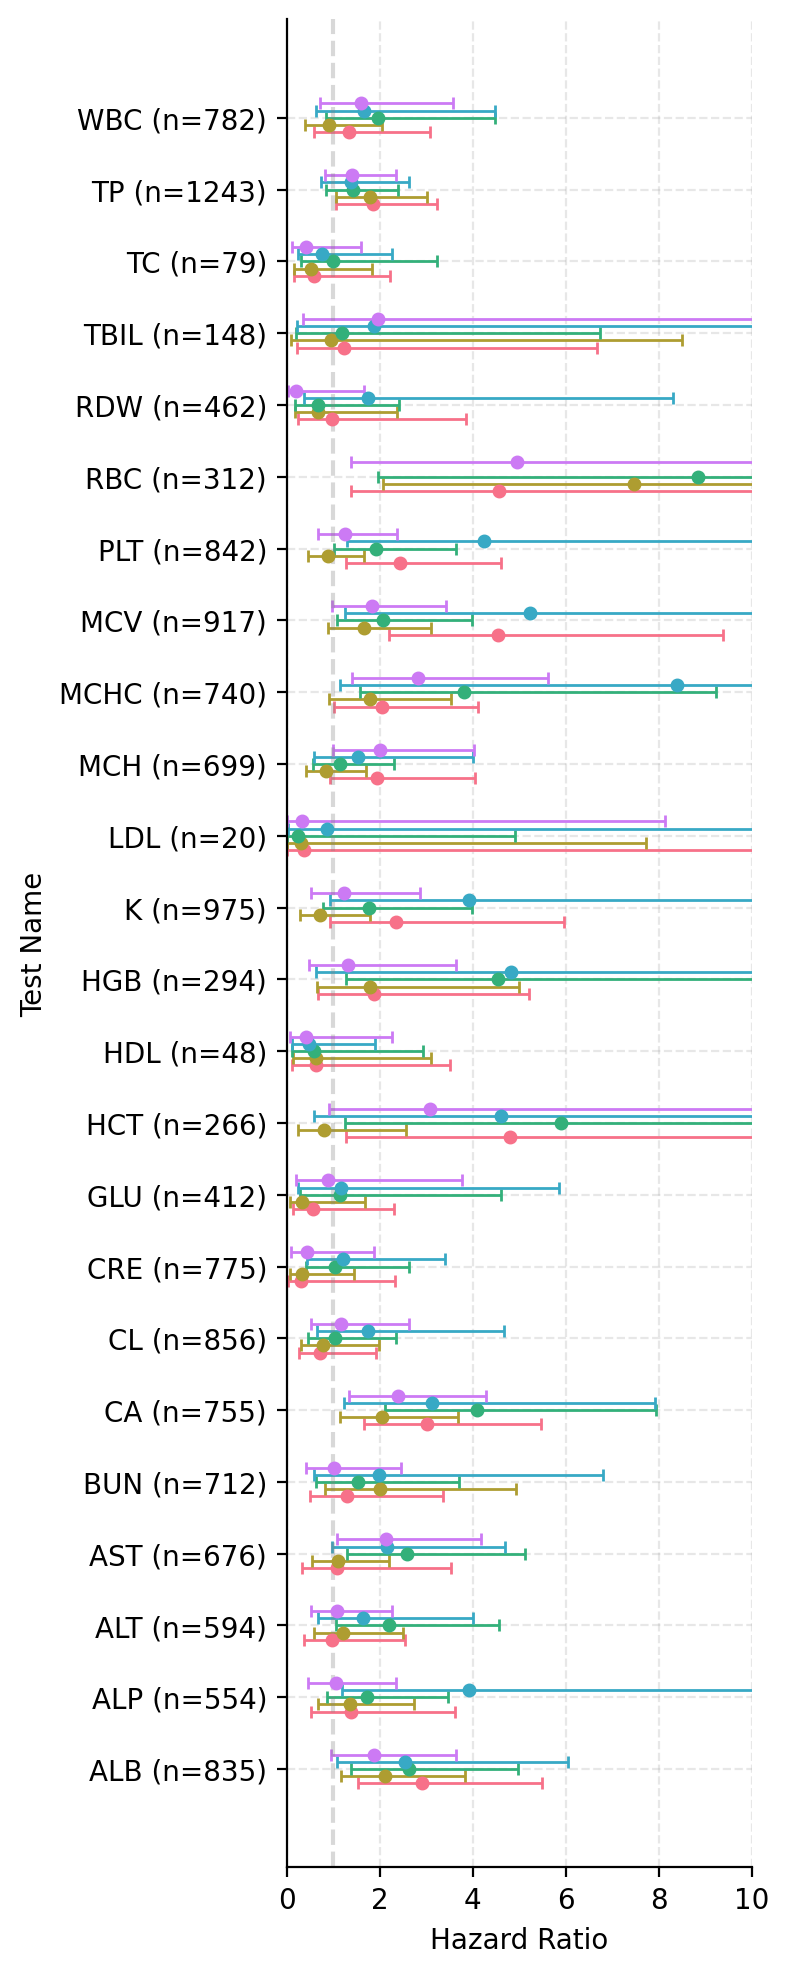

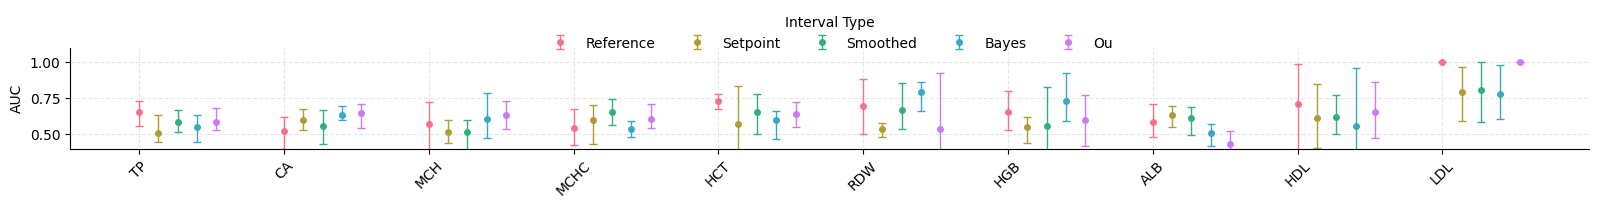

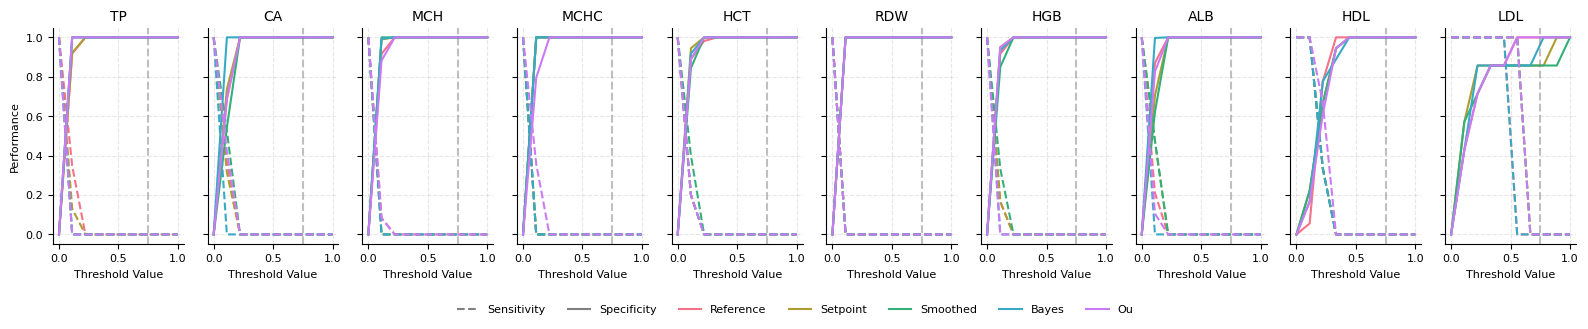

mace
[569, 557, 620, 705, 750, 768, 865, 790, 382, 265, 59, 287, 990, 24, 702, 763, 930, 860, 314, 456, 163, 93, 861, 777]
Train Data Positive : [('ALB', 70), ('ALP', 54), ('ALT', 64), ('AST', 76), ('BUN', 35), ('CA', 78), ('CL', 41), ('CRE', 34), ('GLU', 13), ('HCT', 20), ('HDL', 9), ('HGB', 23), ('K', 48), ('LDL', 6), ('MCH', 64), ('MCHC', 78), ('MCV', 91), ('PLT', 78), ('RBC', 26), ('RDW', 23), ('TBIL', 7), ('TC', 15), ('TP', 111), ('WBC', 45)]
Test Data Positive : [('ALB', 30), ('ALP', 23), ('ALT', 27), ('AST', 32), ('BUN', 15), ('CA', 34), ('CL', 18), ('CRE', 15), ('GLU', 6), ('HCT', 8), ('HDL', 3), ('HGB', 10), ('K', 21), ('LDL', 3), ('MCH', 27), ('MCHC', 34), ('MCV', 39), ('PLT', 33), ('RBC', 11), ('RDW', 10), ('TBIL', 3), ('TC', 7), ('TP', 47), ('WBC', 19)]


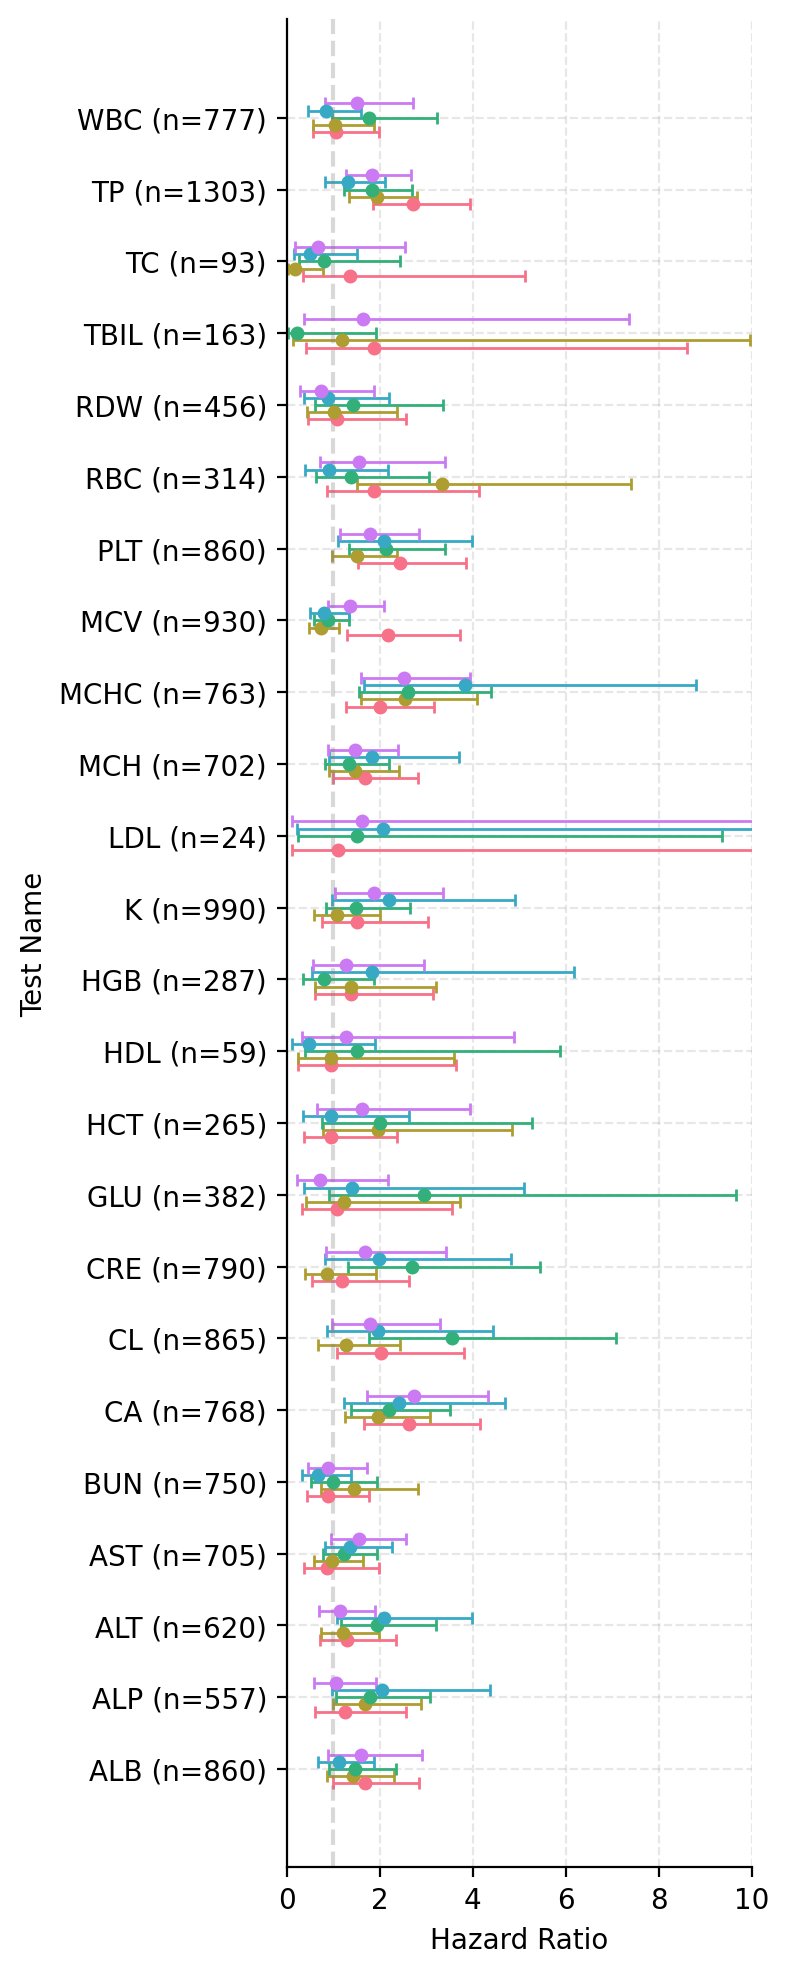

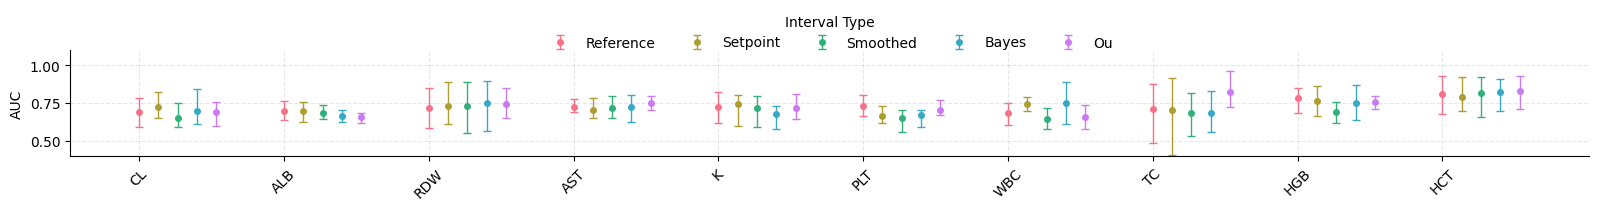

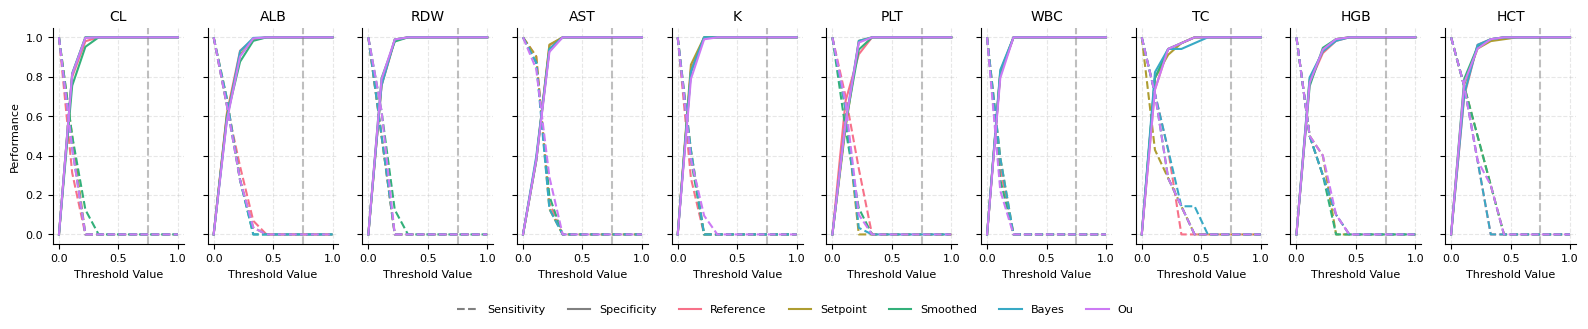

ckd
[578, 603, 655, 746, 847, 810, 930, 902, 401, 294, 60, 322, 1051, 26, 741, 817, 989, 915, 352, 484, 178, 84, 918, 825]
Train Data Positive : [('ALB', 57), ('ALP', 48), ('ALT', 49), ('AST', 55), ('BUN', 29), ('CA', 57), ('CL', 33), ('CRE', 33), ('GLU', 15), ('HCT', 15), ('HDL', 10), ('HGB', 17), ('K', 38), ('LDL', 6), ('MCH', 40), ('MCHC', 43), ('MCV', 57), ('PLT', 50), ('RBC', 20), ('RDW', 14), ('TBIL', 8), ('TC', 15), ('TP', 85), ('WBC', 30)]
Test Data Positive : [('ALB', 24), ('ALP', 21), ('ALT', 21), ('AST', 24), ('BUN', 13), ('CA', 24), ('CL', 14), ('CRE', 14), ('GLU', 6), ('HCT', 7), ('HDL', 4), ('HGB', 7), ('K', 16), ('LDL', 3), ('MCH', 17), ('MCHC', 18), ('MCV', 25), ('PLT', 21), ('RBC', 8), ('RDW', 6), ('TBIL', 4), ('TC', 7), ('TP', 36), ('WBC', 13)]


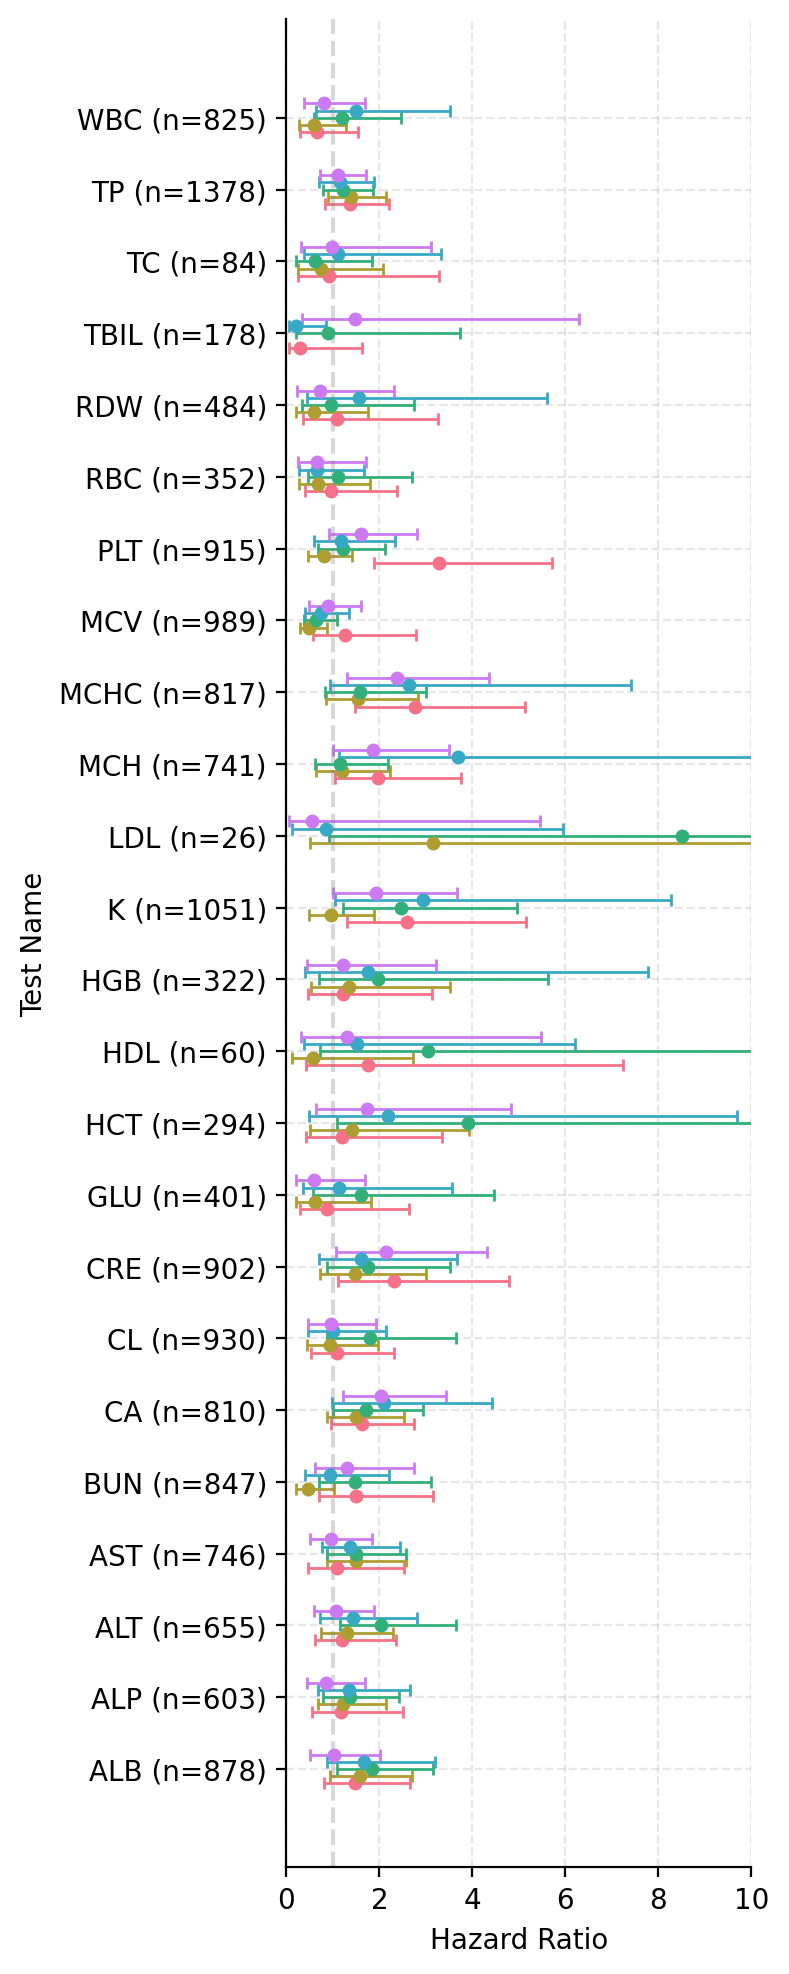

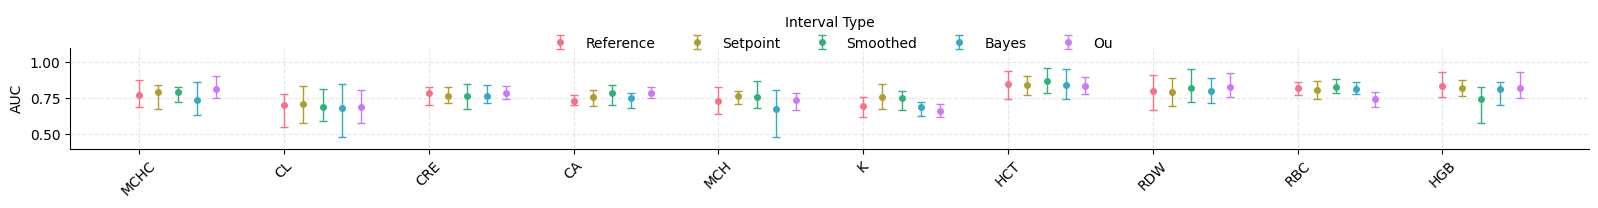

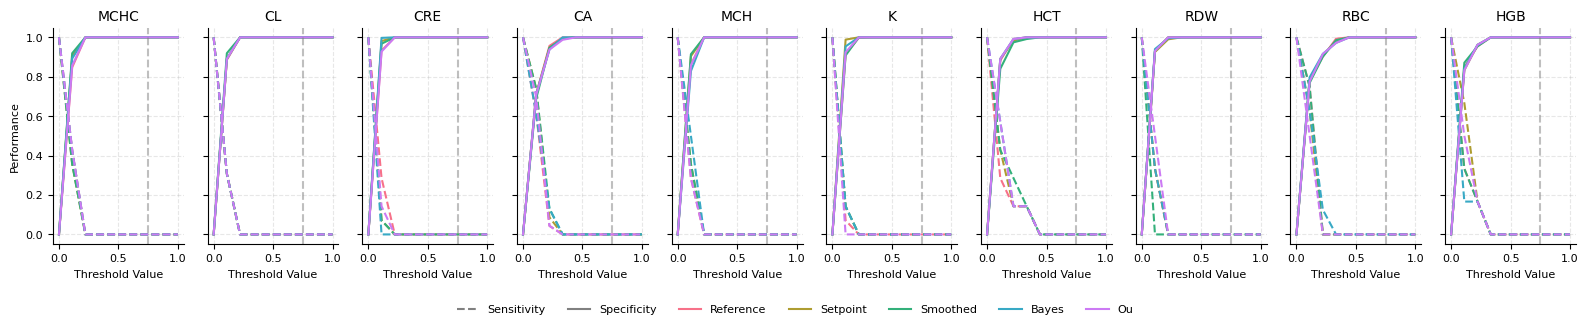

In [39]:
cutoff = 0.80
min_tests = 5
method_str = f'method:cutoff_percent:{cutoff}_min_tests:{min_tests}'

min_followup_days = 1
max_followup_days = 365*1

year_prediction = 3

run_pipeline(method_str, min_followup_days, max_followup_days, year_prediction)

In [24]:
# min_gap = 30
# year_index = 2016
# min_tests = 5
# method_str = f'method:index_index_year:{year_index}_min_gap:{min_gap}_min_tests:{min_tests}'

# min_followup_days = 1
# max_followup_days = 365*1

# year_prediction = 3

# run_pipeline(method_str, min_followup_days, max_followup_days, year_prediction)